### Import

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Define Directory

In [2]:
dir = {
    'input': '../demo_input/',
    'general_output': '../test_output/general/',
    'human_output': '../test_output/human/',
    'machine_output': '../test_output/machine/',
    'nature_output': '../test_output/nature/',
    'model': '../model/',
    'classifier': '../classification_data/'
}

In [3]:
def calculate_snr(clean_signal, denoised_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels.
    
    Args:
    clean_signal (torch.Tensor): Ground truth clean signal, shape (1, 1, H, W)
    denoised_signal (torch.Tensor): Model's output signal, shape (1, 1, H, W)
    
    Returns:
    float: SNR value in decibels.
    """
    assert clean_signal.shape == denoised_signal.shape, "Shapes of input tensors must match."
    clean_signal = clean_signal.squeeze()
    denoised_signal = denoised_signal.squeeze()
    signal_power = torch.mean(clean_signal ** 2)
    noise_power = torch.mean((clean_signal - denoised_signal) ** 2)
    if noise_power == 0:
        return float('inf')
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()

### Classify Model

In [4]:
class MelClassifier(nn.Module):
    def __init__(self, input_channels):
        super(MelClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = None  # 延遲初始化
        
    def forward(self, x):
        x = self.features(x)
        if self.classifier is None:  # 第一次執行 forward 時初始化
            num_features = x.view(x.size(0), -1).size(1)
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 3)
            ).to(x.device)
        x = self.classifier(x)
        return x

### DAE Model

In [5]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

### Load Model

In [6]:
model_general = torch.load(dir['model'] + "general_model.pth")
model_human = torch.load(dir['model'] + "human_model.pth")
model_machine = torch.load(dir['model'] + "machine_model.pth")
model_nature = torch.load(dir['model'] + "nature_model.pth")
model_classify = torch.load(dir['classifier'] + "classify_model.pth")

C:\Users\Utin Liu\AppData\Local\Temp\ipykernel_14216\1545760392.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_general = torch.load(dir['model'] + "general_model.

### Define Mel Transform Arguments

In [7]:
# MelSpectrogram參數 (勿動)
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

(1, 128, 157)


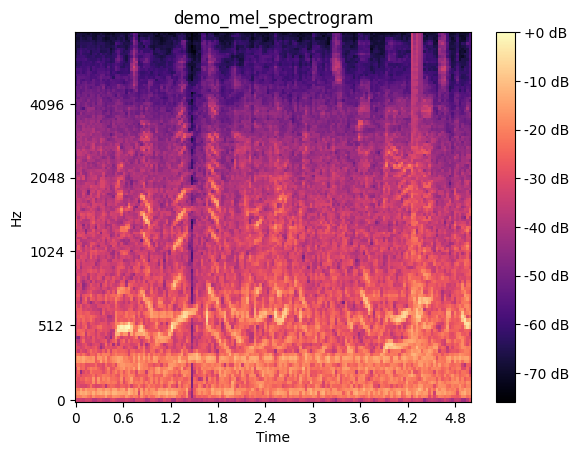

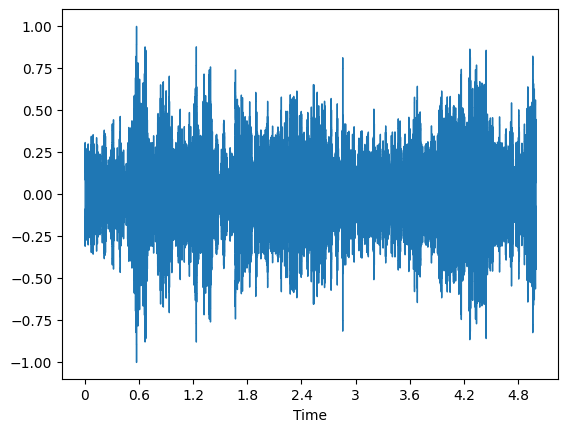

In [8]:
# MIXED
mixed_waveform, sample_rate = librosa.load(dir['input'] + 'demo.wav', sr=sample_rate)

sample_mixed_mel_spectrogram_db = np.load('../machine/mixed/0.npy')

# if sr != sample_rate:
#     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# cut to fit the duration
if len(mixed_waveform) > sample_rate * duration:
    mixed_waveform = mixed_waveform[:sample_rate * duration]

mixed_mel_spectrogram = librosa.feature.melspectrogram(
    y=mixed_waveform,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

mixed_mel_spectrogram_db = librosa.power_to_db(
    mixed_mel_spectrogram, 
    ref=np.max, 
    amin=1e-10  # 避免log(0)
)

mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
sample_mixed_mel_tensor = torch.tensor(sample_mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)

mixed_mel_nparray = mixed_mel_tensor.numpy()
sample_mixed_mel_nparray = sample_mixed_mel_tensor.numpy()

print(mixed_mel_nparray.shape)

fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_nparray[0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='demo_mel_spectrogram')
plt.show()
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

mixed_input = librosa.db_to_power(mixed_mel_spectrogram_db)
mixed_input = librosa.feature.inverse.mel_to_audio(mixed_input, sr=sample_rate, n_iter=500)
mixed_input = mixed_input / np.max(np.abs(mixed_input))

soundfile.write(dir['input'] + 'original.wav', mixed_input, sample_rate)

librosa.display.waveshow(mixed_input, sr=sample_rate)

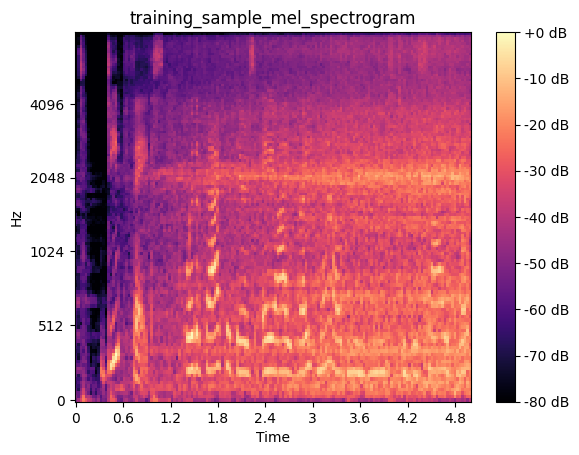

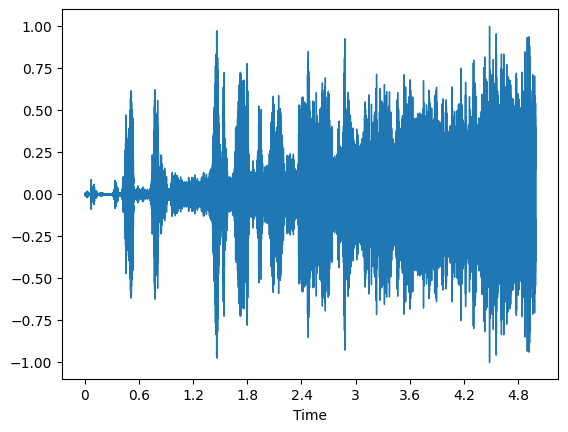

In [9]:
fig, ax = plt.subplots()
img = librosa.display.specshow(sample_mixed_mel_nparray[0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='training_sample_mel_spectrogram')
plt.show()
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

sample_mixed_input = librosa.db_to_power(sample_mixed_mel_spectrogram_db)
sample_mixed_input = librosa.feature.inverse.mel_to_audio(sample_mixed_input, sr=sample_rate, n_iter=500)
sample_mixed_input = sample_mixed_input / np.max(np.abs(sample_mixed_input))

soundfile.write(dir['input'] + 'training_original.wav', sample_mixed_input, sample_rate)

librosa.display.waveshow(sample_mixed_input, sr=sample_rate)

torch.Size([1, 128, 157])
torch.Size([1, 128, 160])
torch.Size([1, 1, 128, 160])
torch.Size([1, 1, 128, 157])


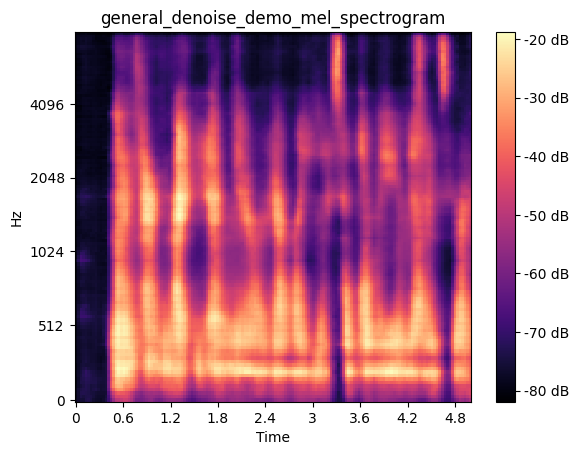

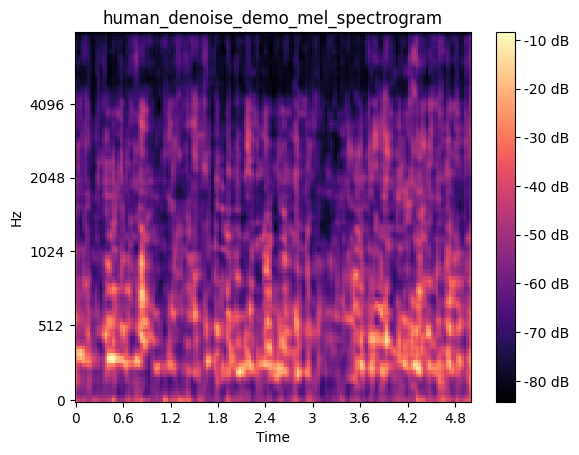

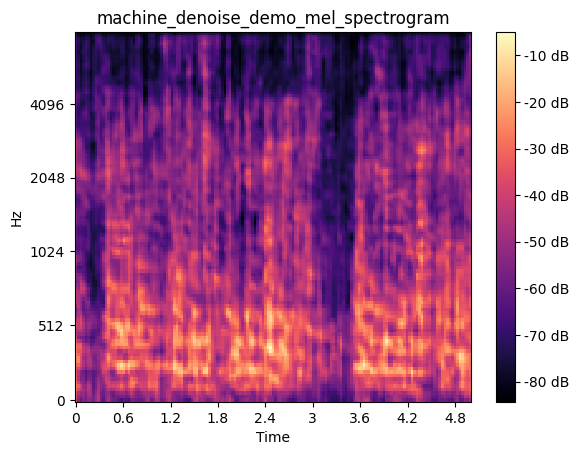

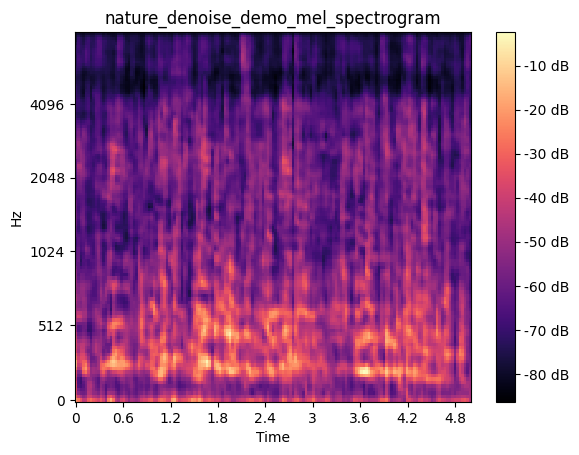

Label = 2
Label_train = 2


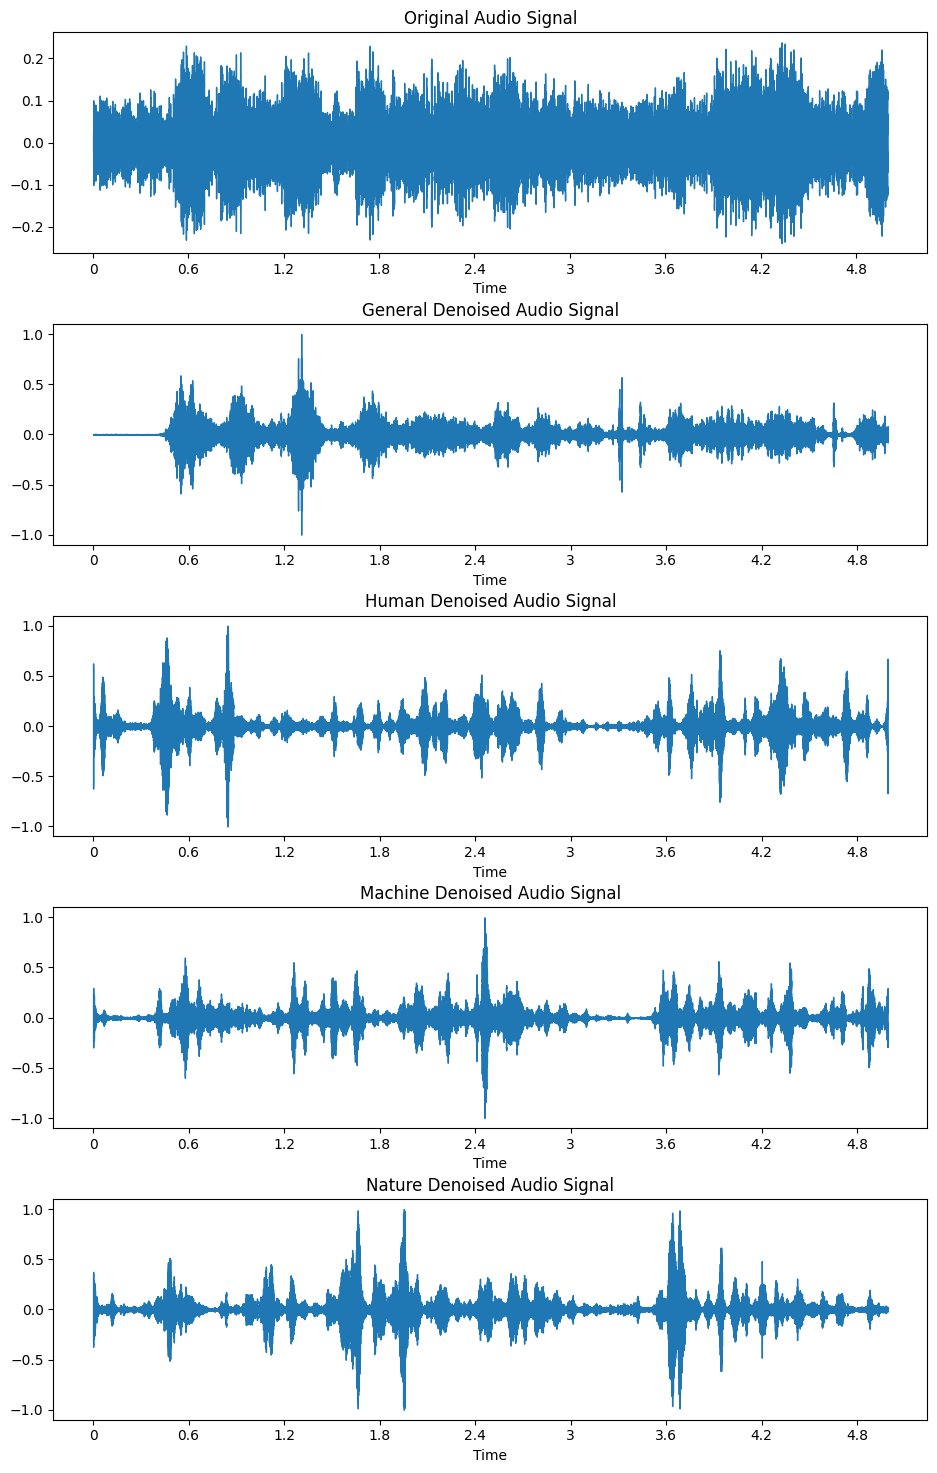

In [10]:
# DENOISED
model_general.eval()
model_human.eval()
model_machine.eval()
model_nature.eval()
model_classify.eval()

print(mixed_mel_tensor.shape)

label = model_classify(mixed_mel_tensor.unsqueeze(0))
label = torch.argmax(label, dim=1).item()
label_train = model_classify(sample_mixed_mel_tensor.unsqueeze(0))
label_train = torch.argmax(label_train, dim=1).item()

target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_tensor.shape[2])]
mixed_mel_nparray = np.pad(mixed_mel_nparray, pad_width=pad_width, mode='constant', constant_values=0)
mixed_mel_tensor = torch.tensor(mixed_mel_nparray, dtype=torch.float32)
sample_mixed_mel_nparray = np.pad(sample_mixed_mel_nparray, pad_width=pad_width, mode='constant', constant_values=0)
sample_mixed_mel_tensor = torch.tensor(sample_mixed_mel_nparray, dtype=torch.float32)

print(mixed_mel_tensor.shape)

denoised_output_general = model_general(mixed_mel_tensor.unsqueeze(0))
denoised_output_human = model_human(mixed_mel_tensor.unsqueeze(0))
denoised_output_machine = model_machine(mixed_mel_tensor.unsqueeze(0))
denoised_output_nature = model_nature(mixed_mel_tensor.unsqueeze(0))

sample_denoised_output_general = model_general(sample_mixed_mel_tensor.unsqueeze(0))
sample_denoised_output_human = model_human(sample_mixed_mel_tensor.unsqueeze(0))
sample_denoised_output_machine = model_machine(sample_mixed_mel_tensor.unsqueeze(0))
sample_denoised_output_nature = model_nature(sample_mixed_mel_tensor.unsqueeze(0))

print(denoised_output_general.shape)

denoised_output_general = denoised_output_general[:, :, :, :157]
denoised_output_human = denoised_output_human[:, :, :, :157]
denoised_output_machine = denoised_output_machine[:, :, :, :157]
denoised_output_nature = denoised_output_nature[:, :, :, :157]

sample_denoised_output_general = sample_denoised_output_general[:, :, :, :157]
sample_denoised_output_human = sample_denoised_output_human[:, :, :, :157]
sample_denoised_output_machine = sample_denoised_output_machine[:, :, :, :157]
sample_denoised_output_nature = sample_denoised_output_nature[:, :, :, :157]

print(denoised_output_general.shape)

denoised_output_general = denoised_output_general.squeeze(0).squeeze(0).detach().numpy()
denoised_output_human = denoised_output_human.squeeze(0).squeeze(0).detach().numpy()
denoised_output_machine = denoised_output_machine.squeeze(0).squeeze(0).detach().numpy()
denoised_output_nature = denoised_output_nature.squeeze(0).squeeze(0).detach().numpy()

sample_denoised_output_general = sample_denoised_output_general.squeeze(0).squeeze(0).detach().numpy()
sample_denoised_output_human = sample_denoised_output_human.squeeze(0).squeeze(0).detach().numpy()
sample_denoised_output_machine = sample_denoised_output_machine.squeeze(0).squeeze(0).detach().numpy()
sample_denoised_output_nature = sample_denoised_output_nature.squeeze(0).squeeze(0).detach().numpy()

fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output_general, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='general_denoise_demo_mel_spectrogram')
plt.show()
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output_human, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='human_denoise_demo_mel_spectrogram')
plt.show()
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output_machine, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='machine_denoise_demo_mel_spectrogram')
plt.show()
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output_nature, sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='nature_denoise_demo_mel_spectrogram')
plt.show()
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

denoised_output_general = librosa.db_to_power(denoised_output_general)
denoised_output_human = librosa.db_to_power(denoised_output_human)
denoised_output_machine = librosa.db_to_power(denoised_output_machine)
denoised_output_nature = librosa.db_to_power(denoised_output_nature)

sample_denoised_output_general = librosa.db_to_power(sample_denoised_output_general)
sample_denoised_output_human = librosa.db_to_power(sample_denoised_output_human)
sample_denoised_output_machine = librosa.db_to_power(sample_denoised_output_machine)
sample_denoised_output_nature = librosa.db_to_power(sample_denoised_output_nature)

audio_signal_general = librosa.feature.inverse.mel_to_audio(denoised_output_general, sr=sample_rate, n_iter=500)
audio_signal_human = librosa.feature.inverse.mel_to_audio(denoised_output_human, sr=sample_rate, n_iter=500)
audio_signal_machine = librosa.feature.inverse.mel_to_audio(denoised_output_machine, sr=sample_rate, n_iter=500)
audio_signal_nature = librosa.feature.inverse.mel_to_audio(denoised_output_nature, sr=sample_rate, n_iter=500)

sample_audio_signal_general = librosa.feature.inverse.mel_to_audio(sample_denoised_output_general, sr=sample_rate, n_iter=500)
sample_audio_signal_human = librosa.feature.inverse.mel_to_audio(sample_denoised_output_human, sr=sample_rate, n_iter=500)
sample_audio_signal_machine = librosa.feature.inverse.mel_to_audio(sample_denoised_output_machine, sr=sample_rate, n_iter=500)
sample_audio_signal_nature = librosa.feature.inverse.mel_to_audio(sample_denoised_output_nature, sr=sample_rate, n_iter=500)

audio_signal_general = audio_signal_general / np.max(np.abs(audio_signal_general))
audio_signal_human = audio_signal_human / np.max(np.abs(audio_signal_human))
audio_signal_machine = audio_signal_machine / np.max(np.abs(audio_signal_machine))
audio_signal_nature = audio_signal_nature / np.max(np.abs(audio_signal_nature))

sample_audio_signal_general = sample_audio_signal_general / np.max(np.abs(sample_audio_signal_general))
sample_audio_signal_human = sample_audio_signal_human / np.max(np.abs(sample_audio_signal_human))
sample_audio_signal_machine = sample_audio_signal_machine / np.max(np.abs(sample_audio_signal_machine))
sample_audio_signal_nature = sample_audio_signal_nature / np.max(np.abs(sample_audio_signal_nature))

# librosa.display.waveshow(audio_signal, sr=sample_rate)

print(f"Label = {label}")
print(f"Label_train = {label_train}")

# soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
soundfile.write(dir['general_output'] + 'denoise_demo.wav', audio_signal_general, sample_rate)
soundfile.write(dir['human_output'] + 'denoise_demo.wav', audio_signal_human, sample_rate)
soundfile.write(dir['machine_output'] + 'denoise_demo.wav', audio_signal_machine, sample_rate)
soundfile.write(dir['nature_output'] + 'denoise_demo.wav', audio_signal_nature, sample_rate)

soundfile.write(dir['general_output'] + 'sample_denoise_demo.wav', sample_audio_signal_general, sample_rate)
soundfile.write(dir['human_output'] + 'sample_denoise_demo.wav', sample_audio_signal_human, sample_rate)
soundfile.write(dir['machine_output'] + 'sample_denoise_demo.wav', sample_audio_signal_machine, sample_rate)
soundfile.write(dir['nature_output'] + 'sample_denoise_demo.wav', sample_audio_signal_nature, sample_rate)

# librosa.display.waveshow(audio_signal_general, sr=sample_rate)
# librosa.display.waveshow(audio_signal_human, sr=sample_rate)
# librosa.display.waveshow(audio_signal_machine, sr=sample_rate)
# librosa.display.waveshow(audio_signal_nature, sr=sample_rate)

# 假設有四個音頻信號和取樣率
# audio_signal_general, audio_signal_human, audio_signal_machine, audio_signal_nature
# sample_rate 是它們的取樣率

# 創建子圖
fig, axes = plt.subplots(5, 1, figsize=(10, 15))  # 5 個子圖，垂直排列，設置圖表大小
fig.tight_layout(pad=3.0)  # 調整子圖間距

# 繪製每個波形
librosa.display.waveshow(mixed_waveform, sr=sample_rate, ax=axes[0])
axes[0].set_title("Original Audio Signal")

librosa.display.waveshow(audio_signal_general, sr=sample_rate, ax=axes[1])
axes[1].set_title("General Denoised Audio Signal")

librosa.display.waveshow(audio_signal_human, sr=sample_rate, ax=axes[2])
axes[2].set_title("Human Denoised Audio Signal")

librosa.display.waveshow(audio_signal_machine, sr=sample_rate, ax=axes[3])
axes[3].set_title("Machine Denoised Audio Signal")

librosa.display.waveshow(audio_signal_nature, sr=sample_rate, ax=axes[4])
axes[4].set_title("Nature Denoised Audio Signal")

# 顯示圖表
plt.show()